In [4]:
import numpy as np
import pandas as pd
import keras
from keras import layers
import matplotlib.pyplot as plt

In [5]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

In [6]:
df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(df_small_noise_url, parse_dates = True, index_col = "timestamp")

In [7]:
df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

In [8]:
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


from matplotlib import pyplot as plt
_df_0['value'].plot(kind='hist', bins=20, title='value')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['value'].plot(kind='line', figsize=(8, 4), title='value')
plt.gca().spines[['top', 'right']].set_visible(False)

In [9]:
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


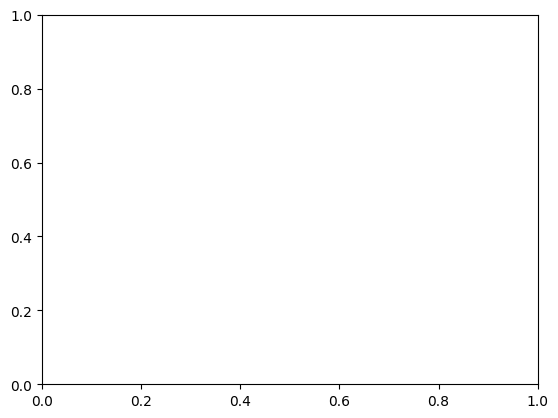

In [10]:
fig, ax = plt.subplots()

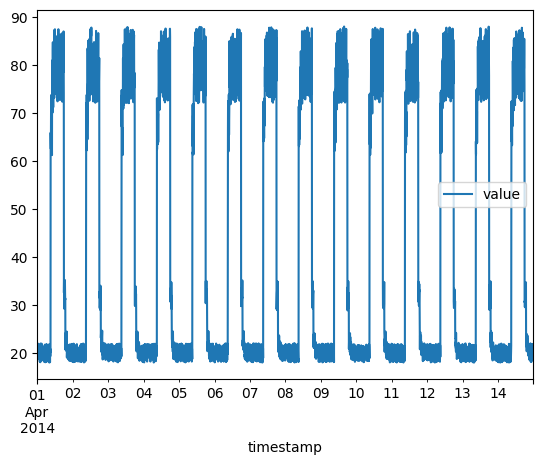

In [15]:
fig, ax = plt.subplots()
df_small_noise.plot(legend = True, ax=ax)
plt.show()

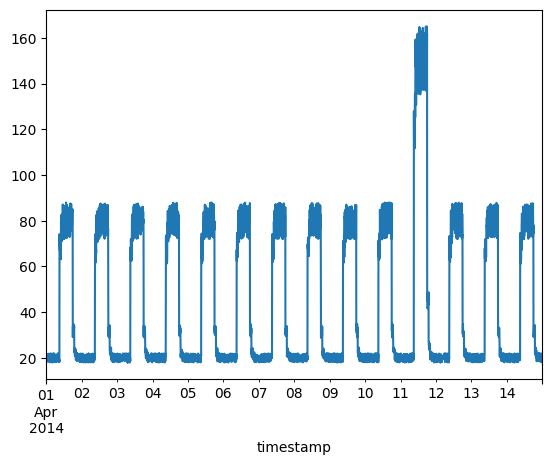

In [17]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend = False, ax= ax)
plt.show()

In [18]:
training_mean = df_small_noise.mean()
training_sd = df_small_noise.std()

In [19]:
training_mean

,0
value,42.438353


In [20]:
training_sd

,0
value,28.077122


In [22]:
df_training_value = (df_small_noise - training_mean) / training_sd

In [23]:
df_training_value

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173
...,...
2014-04-14 23:35:00,-0.791647
2014-04-14 23:40:00,-0.780255
2014-04-14 23:45:00,-0.833640


In [24]:
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


In [25]:
TIME_STEPS = 288

def create_seq(values, time_steps = TIME_STEPS):
  output = []
  for i in range(len(values) - time_steps + 1):
    output.append(values[i : (i + time_steps)])
  return np.stack(output)

x_train = create_seq(df_training_value.values)

In [29]:
x_train.shape

(3745, 288, 1)

In [30]:
model = keras.Sequential(
    [
        layers.Input(shape = (x_train.shape[1], x_train.shape[2])),

        layers.Conv1D(
            filters = 32,
            kernel_size = 7,
            padding = "same",
            strides = 2,
            activation = "relu",
        ),

        layers.Dropout(rate = 0.2),

        layers.Conv1D(
            filters = 32,
            kernel_size = 7,
            padding = "same",
            strides = 2,
            activation = "relu",
        ),

        layers.Conv1DTranspose(
            filters = 32,
            kernel_size = 7,
            padding = "same",
            strides = 2,
            activation = "relu",
        ),
        layers.Dropout(rate = 0.2),
        layers.Conv1DTranspose(
            filters = 32,
            kernel_size = 7,
            padding = "same",
            strides = 2,
            activation = "relu",
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),

    ]
)


In [31]:
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001), loss = "mse")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 144, 32)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 144, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 72, 32)              │           7,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose (Conv1DTranspose)   │ (None, 144, 32)             │           7,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 144, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_1 (Conv1DTranspose) │ (None, 288, 32)             │           7,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_2 (Conv1DTranspose) │ (None, 288, 1)              │             225 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,081 (86.25 KB)

 Trainable params: 22,081 (86.25 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
hist = model.fit(
    x_train,
    x_train,
    epochs = 25,
    batch_size = 128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, mode = "min")
        ],
)

Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.6653 - val_loss: 0.0667
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.0733 - val_loss: 0.0411
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0508 - val_loss: 0.0318
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 0.0429 - val_loss: 0.0267
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0370 - val_loss: 0.0235
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0324 - val_loss: 0.0209
Epoch 7/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0290 - val_loss: 0.0202
Epoch 8/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 0.0257 - val_loss: 0.0179
Epoch 9/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0233 - val_loss: 0.0169
Epoch 10/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0214 - val_loss: 0.0152
Epoch 11/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0200 - val_loss: 0.0149
Epoch 12/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 

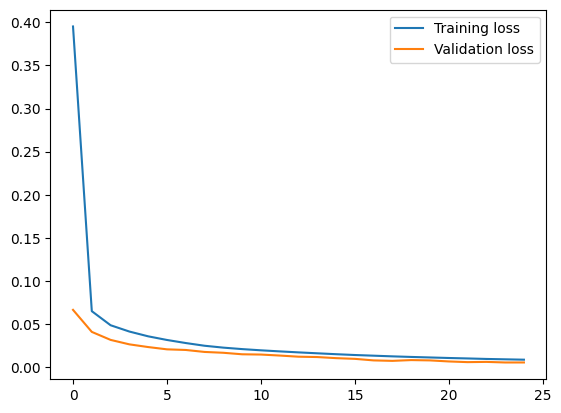

In [33]:
plt.plot(hist.history["loss"], label = "Training loss")
plt.plot(hist.history["val_loss"], label = "Validation loss")
plt.legend()
plt.show()

In [34]:
x_train_pred = model.predict(x_train)

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [35]:
x_train_pred

array([[[-0.7492201 ],
        [-0.7585182 ],
        [-0.77235496],
        ...,
        [-0.7658148 ],
        [-0.79322755],
        [-0.7821266 ]],

       [[-0.75734305],
        [-0.76725507],
        [-0.7742852 ],
        ...,
        [-0.7699263 ],
        [-0.80228376],
        [-0.79117286]],

       [[-0.7496834 ],
        [-0.76163334],
        [-0.77232313],
        ...,
        [-0.7712628 ],
        [-0.7945311 ],
        [-0.77859795]],

       ...,

       [[-0.76661193],
        [-0.7744951 ],
        [-0.78551805],
        ...,
        [-0.7691909 ],
        [-0.7930559 ],
        [-0.78645724]],

       [[-0.7758099 ],
        [-0.78149074],
        [-0.7910229 ],
        ...,
        [-0.775221  ],
        [-0.79961514],
        [-0.78257316]],

       [[-0.7578304 ],
        [-0.77451366],
        [-0.7828394 ],
        ...,
        [-0.7707043 ],
        [-0.7906194 ],
        [-0.7854386 ]]], dtype=float32)

In [36]:
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis = 1)

In [37]:
train_mae_loss

array([[0.05695337],
       [0.05679051],
       [0.05795835],
       ...,
       [0.06031215],
       [0.05686036],
       [0.05692435]])

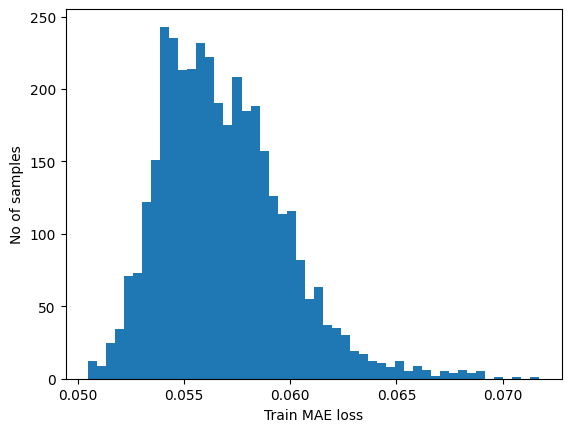

In [38]:
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

In [39]:
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

Reconstruction error threshold:  0.07170899226814756


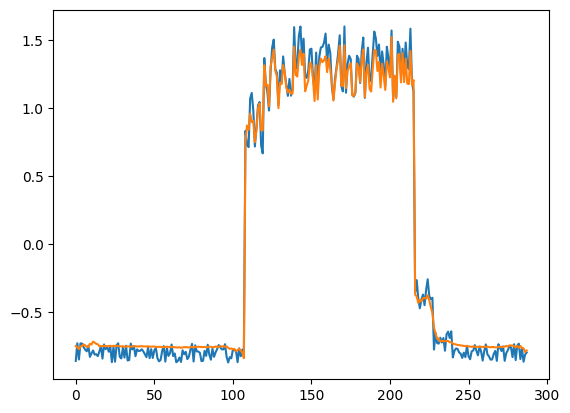

In [40]:
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

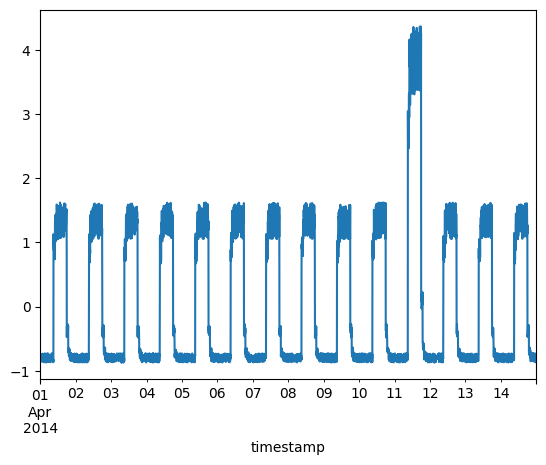

In [42]:
df_test_value = (df_daily_jumpsup - training_mean) / training_sd
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()


In [44]:
# Create sequences from test values.
x_test = create_seq(df_test_value.values)
print("Test input shape: ", x_test.shape)

Test input shape:  (3745, 288, 1)


In [45]:
# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


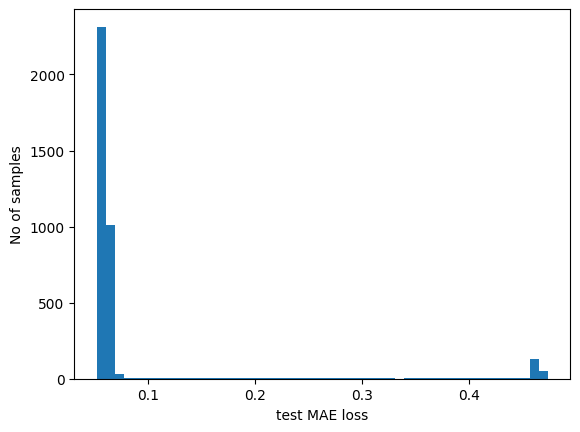

In [46]:
plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

In [47]:
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  403
Indices of anomaly samples:  (array([ 793,  794,  795, 1945, 1946, 2521, 2522, 2523, 2701, 2702, 2703,
       2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714,
       2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725,
       2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736,
       2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747,
       2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758,
       2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769,
       2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780,
       2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791,
       2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802,
       2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813,
       2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824,
       2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2

In [48]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

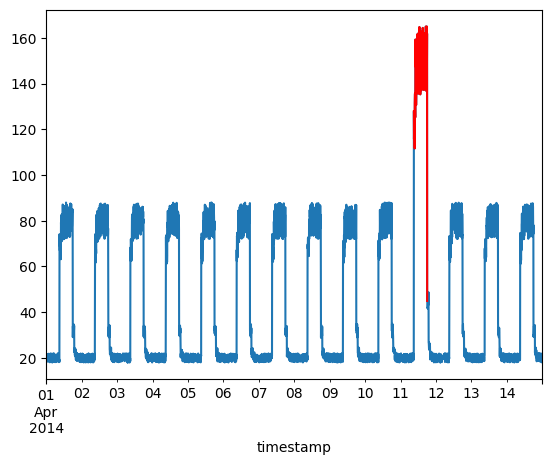

In [51]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()